In [6]:
import numpy as np
import h5py as h5
import sys
import time
import matplotlib.pyplot as plt 


In [7]:
# -- visit function for h5 viewing the structure of files
def visit_func(name, node):
    '''
    Return all groups and datasets name and shapes of h5 file called name
    '''
    if isinstance(node, h5.Group):
        print(node.name)
    elif isinstance(node, h5.Dataset):
        if (node.dtype == 'object') :
            print (node.name, 'is an object Dataset')
        else:
            print('\t', node.name, node.shape)
    else:
        print(node.name, 'is an unknown type')
        
        
def assemble_image(imgs):
    """
    return the assembled image of size [2080,2080]
    with the 4 epix
    input: list of 4 epix map
    output: map of size (2080,2080) assembled
    """
    shape = [704,768]
    edge  = [170,140]
    frame = np.zeros([2080,2080])
    #epix1
    frame[  edge[0]:shape[0]+edge[0],  edge[1]:shape[1]+edge[1]] = np.rot90( imgs[0] , 2)
    #epix2
    frame[  edge[0]:shape[0]+edge[0],-edge[1]-shape[1]:-edge[1]] = np.rot90( imgs[1] , 2)
    #epix3
    frame[-edge[0]-shape[0]:-edge[0],  edge[1]:shape[1]+edge[1]] = imgs[2]
    #epix4
    frame[-edge[0]-shape[0]:-edge[0],-edge[1]-shape[1]:-edge[1]] =  imgs[3] 
    return frame

In [8]:
ls /sdf/data/lcls/ds/xpp/xppl1001021/hdf5/smalldata

cube/                   xppl1001021_Run0035.h5  xppl1001021_Run0053.h5
jungfrau/               xppl1001021_Run0036.h5  xppl1001021_Run0054.h5
xppl1001021_Run0002.h5  xppl1001021_Run0037.h5  xppl1001021_Run0055.h5
xppl1001021_Run0003.h5  xppl1001021_Run0038.h5  xppl1001021_Run0056.h5
xppl1001021_Run0004.h5  xppl1001021_Run0039.h5  xppl1001021_Run0057.h5
xppl1001021_Run0005.h5  xppl1001021_Run0040.h5  xppl1001021_Run0058.h5
xppl1001021_Run0009.h5  xppl1001021_Run0041.h5  xppl1001021_Run0059.h5
xppl1001021_Run0010.h5  xppl1001021_Run0042.h5  xppl1001021_Run0060.h5
xppl1001021_Run0011.h5  xppl1001021_Run0043.h5  xppl1001021_Run0061.h5
xppl1001021_Run0012.h5  xppl1001021_Run0044.h5  xppl1001021_Run0062.h5
xppl1001021_Run0014.h5  xppl1001021_Run0045.h5  xppl1001021_Run0063.h5
xppl1001021_Run0015.h5  xppl1001021_Run0046.h5  xppl1001021_Run0064.h5
xppl1001021_Run0024.h5  xppl1001021_Run0047.h5  xppl1001021_Run0065.h5
xppl1001021_Run0029.h5  xppl1001021_Run0048.h5  xppl1001021_Run0066.h5
xppl10

In [9]:

exp_name = 'xppl1001021'
run_num=46
output_path = '/sdf/data/lcls/ds/xpp/{}/results/output/'.format(exp_name)


smalldata_path = '/sdf/data/lcls/ds/xpp/{}/hdf5/smalldata/'.format(exp_name)
#smalldata_path = '/sdf/data/lcls/ds/xpp/xppl1001021/results/mb/shared/'.format(exp_name)


In [10]:
with h5.File(smalldata_path + '{}_Run{:04d}.h5'.format(exp_name, run_num),'r') as f:
    print(f.keys())

    f['epix_alc5'].visititems(visit_func)
    
    #mask = f['UserDataCfg/epix_alc{}/mask'.format(epix)][()]#this is the general mask we use for photonization    


<KeysViewHDF5 ['Sums', 'UserDataCfg', 'adc', 'ai', 'damage', 'diode2', 'diodeU', 'ebeam', 'epics', 'epicsAll', 'epix_alc1', 'epix_alc1_env', 'epix_alc2', 'epix_alc2_env', 'epix_alc3', 'epix_alc3_env', 'epix_alc4', 'epix_alc4_env', 'epix_alc5', 'epix_alc5_env', 'event_time', 'evr', 'feeBld', 'fiducials', 'gas_detector', 'ipm2', 'ipm_hx2', 'jungfrau1M_alcove', 'lightStatus', 'lombpm', 'lomdiode', 'scan']>
/epix_alc5/ragged_droplet_photon_i is an object Dataset
/epix_alc5/ragged_droplet_photon_j is an object Dataset
/epix_alc5/ragged_droplet_prob_0 is an object Dataset


In [18]:

# Define parameters -- update!

output_path = ''
smalldata_path = '/sdf/data/lcls/ds/xpp/{}/hdf5/smalldata/'.format(exp_name)
#smalldata_path = '/sdf/data/lcls/ds/xpp/xppl1001021/results/mb/shared/'.format(exp_name)


# Define functions
def reconstruct_img(photons_i, photons_j, shape):
    nx, ny = shape
    phot_img, _,_ = np.histogram2d(photons_j+0.5, photons_i+0.5, bins=[np.arange(nx+1),np.arange(ny+1)])                         
    return phot_img

#user_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/kyounes/mask/standard_mask.npy')
#user_mask = user_mask.astype(bool)
mask=[[],[],[],[]]
N_epix=4

mask[0]=np.ones([704, 768])
mask[1]=np.ones([704, 768])
mask[2]=np.ones([704, 768])
mask[3]=np.ones([704, 768])

mask[0][0:354,370:390]=0
mask[0][0:154,680:710]=0

mask[1][350:,635]=0
mask[1][350:,636]=0
mask[1][350:,637]=0
mask[3][507:509,477:479]=0

pixel_out=8
pixel_center1=383
pixel_center2=352
deltapixel=3

for epix in range(N_epix):
    mask[epix][0:pixel_out,:]=0
    mask[epix][:,0:pixel_out]=0
    mask[epix][-pixel_out:,:]=0
    mask[epix][:,-pixel_out:]=0
    
    mask[epix][:,pixel_center1-deltapixel:pixel_center1+deltapixel]=0
    mask[epix][pixel_center2-deltapixel:pixel_center2+deltapixel,:]=0

# Load the result from droplet analysis
with h5.File(smalldata_path + '{}_Run{:04d}.h5'.format(exp_name, run_num),'r') as f:
    print(f.keys())
    photons_i = []
    photons_j = []
    
    total_mask = []#this is the general mask we use for photonization
    
    for epix in range(N_epix):
        print(epix+1)
        photons_j.append( f['epix_alc{}/ragged_droplet_photon_j'.format(epix+1)][:])
        photons_i.append( f['epix_alc{}/ragged_droplet_photon_i'.format(epix+1)][:])
        mask_standard =      f['UserDataCfg/epix_alc{}/mask'.format(epix+1)][()]
        # Load all the masks
        mask_standard = mask_standard.astype(bool)
        bad_pixel_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/haoyuan/mask_epix{}_combined_hy_v1.npy'.format(epix+1))
        total_mask.append((mask[epix]*mask_standard  * bad_pixel_mask).astype(bool))

    i_sample = f['lombpm']['channels'][:,1]
    cc = np.array(f['ai/ch03'])
    vcc = np.array(f['ai/ch02'])
    


# Process each pattern in this run
shape = mask_standard.shape
nframe = int(len(photons_i[0]))
#imgs_reconstruct = np.zeros(np.r_[nframe, shape])

pixel_num = float(np.sum(total_mask))

# Create holders for the result
kbar = np.zeros([N_epix, nframe])
beta = np.zeros([N_epix, nframe])
p0 = np.zeros([N_epix, nframe])
p1 = np.zeros([N_epix, nframe])
p2 = np.zeros([N_epix, nframe])
p3 = np.zeros([N_epix, nframe])

# Get the total photon count and probability per shot for all runs and patterns
tic = time.time()
for i in range(nframe):
    for epix in range (N_epix):
        imgs_reconstruct = reconstruct_img(photons_i[epix][i], photons_j[epix][i], shape)
        kbar[epix,i] += np.sum(imgs_reconstruct[total_mask[epix]])/ pixel_num
        p, p_bin_edge = np.histogram(imgs_reconstruct[total_mask[epix]].flatten(),bins=[-0.5, 0.5, 1.5, 2.5, 3.5])
    
        p0[epix,i] = p[0] / pixel_num
        p1[epix,i] = p[1] / pixel_num
        p2[epix,i] = p[2] / pixel_num
        p3[epix,i] = p[3] / pixel_num

    if i // 10000 == 0:
        toc = time.time()
        print(i/nframe,toc - tic)
        
# Get the analytical contrast expression

#beta_2ph = (2 * p2 - kbar * p1) / (kbar * (p1 - 2 * p2))


delayStageLocation = f['/epicsAll/sd_delay'][:]
delay = np.mean(0.939 * (delayStageLocation - 6.96))


for epix in range(N_epix):
    beta[epix,:] = (2 * p2[epix,:] - kbar[epix,:] * p1[epix,:]) / (kbar[epix,:] * (p1[epix,:] - 2 * p2[epix,:]))
    
    
#np.savez(output_path + 'contrast_run_{}_delay_{}_pulse_{}'.format(run_num, delay, pulse),## this would be ideal but not implemented
np.savez(output_path + 'contrast_run_{}_delay_{}'.format(run_num, ),## this would be ideal but not implemented
         beta=beta,
         p1=p1,
         p2=p2,
         p0=p0,
         p3=p3,
         kbar=kbar,
         cc=cc,
         vcc=vcc,
         i_sample=i_sample)

<KeysViewHDF5 ['Sums', 'UserDataCfg', 'adc', 'ai', 'damage', 'diode2', 'diodeU', 'ebeam', 'epics', 'epicsAll', 'epix_alc1', 'epix_alc1_env', 'epix_alc2', 'epix_alc2_env', 'epix_alc3', 'epix_alc3_env', 'epix_alc4', 'epix_alc4_env', 'epix_alc5', 'epix_alc5_env', 'event_time', 'evr', 'feeBld', 'fiducials', 'gas_detector', 'ipm2', 'ipm_hx2', 'jungfrau1M_alcove', 'lightStatus', 'lombpm', 'lomdiode', 'scan']>
1
2
3
4
0.0 0.08679342269897461
5.709391949757351e-05 0.16202664375305176
0.00011418783899514702 0.24268484115600586
0.00017128175849272052 0.3126077651977539
0.00022837567799029404 0.3825504779815674
0.00028546959748786756 0.4512641429901123
0.00034256351698544105 0.5193145275115967
0.00039965743648301454 0.5956714153289795
0.0004567513559805881 0.6722712516784668
0.0005138452754781616 0.7416093349456787
0.0005709391949757351 0.8148746490478516
0.0006280331144733086 0.8822855949401855
0.0006851270339708821 0.9495136737823486
0.0007422209534684556 1.01772141456604
0.0007993148729660291 

0.011304596060519555 13.75629997253418
0.011361689980017128 13.823981761932373
0.011418783899514702 13.891809940338135
0.011475877819012275 13.95937991142273
0.011532971738509848 14.02769160270691
0.011590065658007423 14.097304344177246
0.011647159577504996 14.165996551513672
0.011704253497002569 14.240760803222656
0.011761347416500144 14.309176206588745
0.011818441335997716 14.379582166671753
0.01187553525549529 14.44800329208374
0.011932629174992864 14.515124320983887
0.011989723094490437 14.582321882247925
0.01204681701398801 14.651159763336182
0.012103910933485583 14.718337774276733
0.012161004852983158 14.785918712615967
0.01221809877248073 14.854266881942749
0.012275192691978304 14.921107769012451
0.012332286611475878 14.988401174545288
0.012389380530973451 15.056349039077759
0.012446474450471024 15.124187231063843
0.012503568369968599 15.192935228347778
0.012560662289466172 15.261621475219727
0.012617756208963745 15.331355810165405
0.01267485012846132 15.401447296142578
0.012731

0.023294319155009992 28.42232084274292
0.023351413074507565 28.490345239639282
0.023408506994005138 28.55929708480835
0.02346560091350271 28.627357006072998
0.023522694833000287 28.695183753967285
0.02357978875249786 28.76315712928772
0.023636882671995433 28.83030605316162
0.023693976591493006 28.897871494293213
0.02375107051099058 28.96536159515381
0.023808164430488152 29.032690048217773
0.023865258349985728 29.100329399108887
0.0239223522694833 29.171334743499756
0.023979446188980874 29.24278688430786
0.024036540108478447 29.313719272613525
0.02409363402797602 29.38193941116333
0.024150727947473593 29.449140787124634
0.024207821866971166 29.519291400909424
0.024264915786468742 29.587083101272583
0.024322009705966315 29.654900312423706
0.024379103625463888 29.72371554374695
0.02443619754496146 29.792229652404785
0.024493291464459034 29.86021852493286
0.024550385383956607 29.92769479751587
0.024607479303454183 29.99549627304077
0.024664573222951756 30.07000470161438
0.02472166714244933

0.03545532400799315 43.10028672218323
0.03551241792749072 43.16928315162659
0.0355695118469883 43.23728799819946
0.035626605766485867 43.30453038215637
0.03568369968598344 43.37193441390991
0.03574079360548102 43.44037914276123
0.03579788752497859 43.508403062820435
0.035854981444476165 43.57748532295227
0.035912075363973735 43.64573621749878
0.03596916928347131 43.71405625343323
0.03602626320296888 43.7813036441803
0.03608335712246646 43.84852194786072
0.03614045104196403 43.91604518890381
0.0361975449614616 43.98308873176575
0.03625463888095918 44.05139183998108
0.03631173280045675 44.119794845581055
0.036368826719954325 44.190715312957764
0.0364259206394519 44.26858687400818
0.03648301455894947 44.338794469833374
0.03654010847844705 44.41931486129761
0.03659720239794462 44.48905348777771
0.03665429631744219 44.55866312980652
0.03671139023693976 44.62954759597778
0.03676848415643734 44.699955224990845
0.036825578075934916 44.770617961883545
0.036882671995432485 44.840598344802856
0.0

0.047787610619469026 58.01766514778137
0.0478447045389666 58.08831262588501
0.04790179845846417 58.15762138366699
0.04795889237796175 58.227421283721924
0.04801598629745932 58.29765605926514
0.048073080216956894 58.36745476722717
0.04813017413645447 58.43680953979492
0.04818726805595204 58.50555491447449
0.048244361975449616 58.57441329956055
0.048301455894947186 58.643497467041016
0.04835854981444476 58.712372064590454
0.04841564373394233 58.781272888183594
0.04847273765343991 58.851717710494995
0.048529831572937485 58.921223640441895
0.048586925492435054 58.98938703536987
0.04864401941193263 59.057740926742554
0.0487011133314302 59.12694549560547
0.048758207250927776 59.198347330093384
0.04881530117042535 59.26769733428955
0.04887239508992292 59.33976674079895
0.0489294890094205 59.40823984146118
0.04898658292891807 59.47905087471008
0.049043676848415645 59.55199146270752
0.049100770767913214 59.62348484992981
0.04915786468741079 59.69459676742554
0.04921495860690837 59.7693650722503

0.06017699115044248 73.05661201477051
0.06023408506994005 73.12779068946838
0.06029117898943762 73.19846367835999
0.0603482729089352 73.26781988143921
0.06040536682843277 73.33768558502197
0.060462460747930345 73.40553021430969
0.06051955466742792 73.47522163391113
0.06057664858692549 73.54436945915222
0.06063374250642307 73.61362719535828
0.06069083642592064 73.68373537063599
0.06074793034541821 73.75284242630005
0.06080502426491579 73.82091236114502
0.06086211818441336 73.88895273208618
0.060919212103910936 73.95800638198853
0.060976306023408505 74.02627182006836
0.06103339994290608 74.09473896026611
0.06109049386240365 74.16352343559265
0.06114758778190123 74.2334234714508
0.061204681701398804 74.30148267745972
0.06126177562089637 74.37039399147034
0.06131886954039395 74.43822407722473
0.06137596345989152 74.50617694854736
0.061433057379389096 74.57442784309387
0.061490151298886665 74.64271330833435
0.06154724521838424 74.71197438240051
0.06160433913788182 74.78053665161133
0.061661

0.07273765343990865 88.3915147781372
0.07279474735940622 88.46033787727356
0.0728518412789038 88.5281732082367
0.07290893519840137 88.5964994430542
0.07296602911789894 88.66705393791199
0.07302312303739651 88.73843455314636
0.0730802169568941 88.80811738967896
0.07313731087639166 88.87873578071594
0.07319440479588923 88.94831037521362
0.07325149871538682 89.01844882965088
0.07330859263488439 89.08928751945496
0.07336568655438196 89.15772151947021
0.07342278047387953 89.22888946533203
0.07347987439337711 89.29843974113464
0.07353696831287468 89.36628723144531
0.07359406223237225 89.43338751792908
0.07365115615186983 89.50131583213806
0.0737082500713674 89.56975102424622
0.07376534399086497 89.64279198646545
0.07382243791036254 89.71224975585938
0.07387953182986012 89.78021597862244
0.07393662574935769 89.84859371185303
0.07399371966885526 89.91658616065979
0.07405081358835285 89.9845700263977
0.07410790750785042 90.06000804901123
0.07416500142734798 90.13092541694641
0.07422209534684555

0.08524122180987725 103.63567352294922
0.08529831572937482 103.70470786094666
0.0853554096488724 103.77353763580322
0.08541250356836996 103.84382891654968
0.08546959748786755 103.91384029388428
0.08552669140736512 103.98111820220947
0.08558378532686269 104.0494863986969
0.08564087924636027 104.11824440956116
0.08569797316585784 104.18756771087646
0.08575506708535541 104.25541114807129
0.08581216100485298 104.32344198226929
0.08586925492435056 104.39140439033508
0.08592634884384813 104.46032905578613
0.0859834427633457 104.52824378013611
0.08604053668284328 104.59680008888245
0.08609763060234085 104.66565132141113
0.08615472452183842 104.73266458511353
0.08621181844133599 104.80025339126587
0.08626891236083357 104.86753225326538
0.08632600628033114 104.93461346626282
0.08638310019982871 105.00178170204163
0.0864401941193263 105.06993174552917
0.08649728803882387 105.13808369636536
0.08655438195832144 105.20687985420227
0.08661147587781902 105.27972531318665
0.08666856979731659 105.35117

0.0974022266628604 118.60576176643372
0.09745932058235798 118.6759762763977
0.09751641450185555 118.74519348144531
0.09757350842135312 118.81354069709778
0.0976306023408507 118.88263034820557
0.09768769626034828 118.95120477676392
0.09774479017984584 119.02089977264404
0.09780188409934341 119.09218692779541
0.097858978018841 119.16312313079834
0.09791607193833857 119.23434162139893
0.09797316585783614 119.30643963813782
0.09803025977733372 119.37766766548157
0.09808735369683129 119.446298122406
0.09814444761632886 119.51478958129883
0.09820154153582643 119.58324027061462
0.09825863545532401 119.65382266044617
0.09831572937482158 119.72450041770935
0.09837282329431915 119.80846309661865
0.09842991721381673 119.87767267227173
0.0984870111333143 119.94735717773438
0.09854410505281187 120.01732683181763
0.09860119897230944 120.09351992607117
0.09865829289180703 120.16416573524475
0.0987153868113046 120.23245549201965
0.09877248073080216 120.30146980285645
0.09882957465029975 120.3723721504

0.10956323151584356 134.17171835899353
0.10962032543534114 134.2582507133484
0.10967741935483871 134.3480739593506
0.10973451327433628 134.44634747505188
0.10979160719383385 134.53025460243225
0.10984870111333143 134.61334037780762
0.109905795032829 134.70156025886536
0.10996288895232657 134.80256009101868
0.11001998287182416 134.89545845985413
0.11007707679132173 134.98662304878235
0.1101341707108193 135.0716097354889
0.11019126463031687 135.1561233997345
0.11024835854981445 135.24692749977112
0.11030545246931202 135.341965675354
0.11036254638880959 135.43242692947388
0.11041964030830717 135.53527116775513
0.11047673422780474 135.63785195350647
0.11053382814730231 135.72743463516235
0.11059092206679988 135.8240520954132
0.11064801598629746 135.92590737342834
0.11070510990579503 136.03136253356934
0.1107622038252926 136.12017798423767
0.11081929774479019 136.21602725982666
0.11087639166428775 136.3078155517578
0.11093348558378532 136.39910626411438
0.1109905795032829 136.48283529281616

0.12172423636882672 155.08238410949707
0.12178133028832429 155.17584228515625
0.12183842420782187 155.2661964893341
0.12189551812731944 155.35713839530945
0.12195261204681701 155.45053672790527
0.1220097059663146 155.55269956588745
0.12206679988581216 155.64721632003784
0.12212389380530973 155.74837017059326
0.1221809877248073 155.83819317817688
0.12223808164430489 155.93441486358643
0.12229517556380246 156.03111481666565
0.12235226948330002 156.12342596054077
0.12240936340279761 156.21044158935547
0.12246645732229518 156.30218625068665
0.12252355124179275 156.38819122314453
0.12258064516129032 156.48768496513367
0.1226377390807879 156.57824993133545
0.12269483300028547 156.67008352279663
0.12275192691978304 156.75864171981812
0.12280902083928062 156.8494815826416
0.12286611475877819 156.93887948989868
0.12292320867827576 157.02581906318665
0.12298030259777333 157.11824750900269
0.12303739651727091 157.20543932914734
0.12309449043676848 157.29401302337646
0.12315158435626605 157.385758

0.13394233514130746 173.39511442184448
0.13399942906080503 173.4686644077301
0.1340565229803026 173.5453712940216
0.13411361689980017 173.62231540679932
0.13417071081929774 173.69696354866028
0.1342278047387953 173.77281594276428
0.13428489865829288 173.84738755226135
0.13434199257779048 173.92230367660522
0.13439908649728805 173.99599170684814
0.13445618041678561 174.06930923461914
0.13451327433628318 174.1502501964569
0.13457036825578075 174.22637271881104
0.13462746217527832 174.305401802063
0.13468455609477592 174.38617849349976
0.1347416500142735 174.46643471717834
0.13479874393377106 174.53924822807312
0.13485583785326863 174.6113350391388
0.1349129317727662 174.69136238098145
0.13497002569226377 174.77146124839783
0.13502711961176134 174.84630227088928
0.13508421353125893 174.9206759929657
0.1351413074507565 174.99492144584656
0.13519840137025407 175.07295393943787
0.13525549528975164 175.15276670455933
0.1353125892092492 175.22902035713196
0.13536968312874678 175.30422616004944

0.14621752783328576 189.57394194602966
0.14627462175278333 189.64462327957153
0.1463317156722809 189.7178134918213
0.14638880959177847 189.78944206237793
0.14644590351127604 189.85991978645325
0.14650299743077363 189.93180632591248
0.1465600913502712 190.00446438789368
0.14661718526976877 190.07630157470703
0.14667427918926634 190.1482961177826
0.1467313731087639 190.21986556053162
0.14678846702826148 190.29044365882874
0.14684556094775905 190.36228942871094
0.14690265486725665 190.4357590675354
0.14695974878675422 190.51053833961487
0.1470168427062518 190.5827181339264
0.14707393662574936 190.65748000144958
0.14713103054524693 190.72957348823547
0.1471881244647445 190.8017177581787
0.14724521838424207 190.87314867973328
0.14730231230373966 190.9472143650055
0.14735940622323723 191.02029132843018
0.1474165001427348 191.09124493598938
0.14747359406223237 191.163316488266
0.14753068798172994 191.23501896858215
0.1475877819012275 191.30900073051453
0.14764487582072508 191.38109374046326
0

0.15849272052526406 206.47452473640442
0.15854981444476163 206.5489616394043
0.1586069083642592 206.62949347496033
0.15866400228375677 206.7065122127533
0.15872109620325436 206.78581166267395
0.15877819012275193 206.86151099205017
0.1588352840422495 206.9369843006134
0.15889237796174707 207.0104432106018
0.15894947188124464 207.08399486541748
0.1590065658007422 207.15941643714905
0.15906365972023978 207.23403525352478
0.15912075363973738 207.30811667442322
0.15917784755923495 207.38329792022705
0.15923494147873252 207.4564425945282
0.1592920353982301 207.5323944091797
0.15934912931772766 207.6083903312683
0.15940622323722523 207.68580508232117
0.15946331715672282 207.7609202861786
0.1595204110762204 207.83261156082153
0.15957750499571796 207.90591382980347
0.15963459891521553 207.97992253303528
0.1596916928347131 208.05058431625366
0.15974878675421067 208.12311387062073
0.15980588067370824 208.1958713531494
0.15986297459320584 208.26612830162048
0.1599200685127034 208.33660674095154
0.

0.17076791321724236 222.67345929145813
0.17082500713673993 222.74396324157715
0.17088210105623752 222.81389832496643
0.1709391949757351 222.88438534736633
0.17099628889523266 222.95907068252563
0.17105338281473023 223.030268907547
0.1711104767342278 223.10197377204895
0.17116757065372537 223.17268347740173
0.17122466457322294 223.24198412895203
0.17128175849272054 223.3127875328064
0.1713388524122181 223.38295674324036
0.17139594633171568 223.45304012298584
0.17145304025121325 223.52347373962402
0.17151013417071082 223.594379901886
0.17156722809020838 223.6648952960968
0.17162432200970595 223.73574209213257
0.17168141592920355 223.80628275871277
0.17173850984870112 223.8769781589508
0.1717956037681987 223.9474151134491
0.17185269768769626 224.01756262779236
0.17190979160719383 224.0882227420807
0.1719668855266914 224.16116309165955
0.17202397944618897 224.23232102394104
0.17208107336568657 224.30250453948975
0.17213816728518413 224.37305903434753
0.1721952612046817 224.44414019584656
0

0.18310019982871825 238.49659490585327
0.18315729374821582 238.59648156166077
0.1832143876677134 238.69861316680908
0.18327148158721096 238.79837131500244
0.18332857550670853 238.89864873886108
0.1833856694262061 238.9980800151825
0.18344276334570367 239.09618711471558
0.18349985726520127 239.169499874115
0.18355695118469884 239.24256944656372
0.1836140451041964 239.3152952194214
0.18367113902369397 239.3858106136322
0.18372823294319154 239.45563864707947
0.1837853268626891 239.52840614318848
0.1838424207821867 239.59631156921387
0.18389951470168428 239.66547560691833
0.18395660862118185 239.73614144325256
0.18401370254067942 239.80635356903076
0.184070796460177 239.87415480613708
0.18412789037967456 239.94247937202454
0.18418498429917213 240.01240015029907
0.18424207821866972 240.0874538421631
0.1842991721381673 240.15727162361145
0.18435626605766486 240.22622179985046
0.18441335997716243 240.2949342727661
0.18447045389666 240.36350297927856
0.18452754781615757 240.432799577713
0.1845

0.19537539252069655 254.94404983520508
0.19543248644019412 255.02281498908997
0.1954895803596917 255.12235832214355
0.19554667427918926 255.22660112380981
0.19560376819868683 255.32701015472412
0.19566086211818443 255.44716000556946
0.195717956037682 255.52798342704773
0.19577504995717956 255.59956741333008
0.19583214387667713 255.67200756072998
0.1958892377961747 255.74253511428833
0.19594633171567227 255.81490516662598
0.19600342563516984 255.8866672515869
0.19606051955466744 255.959068775177
0.196117613474165 256.0296652317047
0.19617470739366258 256.1010341644287
0.19623180131316015 256.17361187934875
0.19628889523265772 256.24439001083374
0.1963459891521553 256.31483268737793
0.19640308307165286 256.3866035938263
0.19646017699115045 256.4576966762543
0.19651727091064802 256.5287778377533
0.1965743648301456 256.60026454925537
0.19663145874964316 256.6721065044403
0.19668855266914073 256.74199628829956
0.1967456465886383 256.8127682209015
0.19680274050813587 256.8836770057678
0.1968

0.20770767913217242 270.4715540409088
0.20776477305167 270.5426323413849
0.20782186697116756 270.6130621433258
0.20787896089066515 270.6833927631378
0.20793605481016272 270.7520468235016
0.2079931487296603 270.82008123397827
0.20805024264915786 270.8892822265625
0.20810733656865543 270.95723938941956
0.208164430488153 271.02508783340454
0.2082215244076506 271.0931987762451
0.20827861832714817 271.16283082962036
0.20833571224664574 271.2311339378357
0.2083928061661433 271.29820466041565
0.20844990008564088 271.3653826713562
0.20850699400513845 271.43236231803894
0.20856408792463602 271.5002233982086
0.2086211818441336 271.5681664943695
0.20867827576363118 271.636682510376
0.20873536968312875 271.7041676044464
0.20879246360262632 271.77298855781555
0.2088495575221239 271.84011459350586
0.20890665144162146 271.90724635124207
0.20896374536111903 271.97493267059326
0.20902083928061663 272.0426368713379
0.2090779332001142 272.11132621765137
0.20913502711961177 272.18442034721375
0.2091921210

0.2200399657436483 285.5698447227478
0.22009705966314588 285.63668417930603
0.22015415358264345 285.7038776874542
0.22021124750214102 285.7698745727539
0.2202683414216386 285.8349153995514
0.22032543534113616 285.90283489227295
0.22038252926063373 285.9693160057068
0.22043962318013133 286.0372531414032
0.2204967170996289 286.10520792007446
0.22055381101912647 286.1746025085449
0.22061090493862404 286.2429802417755
0.2206679988581216 286.31144094467163
0.22072509277761918 286.3809516429901
0.22078218669711674 286.4487853050232
0.22083928061661434 286.5170636177063
0.2208963745361119 286.5851056575775
0.22095346845560948 286.654705286026
0.22101056237510705 286.7234261035919
0.22106765629460462 286.79201579093933
0.2211247502141022 286.8592782020569
0.22118184413359976 286.9265639781952
0.22123893805309736 286.99345803260803
0.22129603197259493 287.06051230430603
0.2213531258920925 287.1282024383545
0.22141021981159006 287.1963324546814
0.22146731373108763 287.26430225372314
0.2215244076

0.23242934627462175 300.4874782562256
0.23248644019411932 300.5561378002167
0.2325435341136169 300.62576150894165
0.2326006280331145 300.69841289520264
0.23265772195261206 300.7684051990509
0.23271481587210963 300.83562684059143
0.2327719097916072 300.90235900878906
0.23282900371110477 300.9705100059509
0.23288609763060233 301.04069209098816
0.2329431915500999 301.11210656166077
0.2330002854695975 301.1811385154724
0.23305737938909507 301.25482988357544
0.23311447330859264 301.33896493911743
0.2331715672280902 301.40935707092285
0.23322866114758778 301.48540902137756
0.23328575506708535 301.5559673309326
0.23334284898658292 301.62628984451294
0.23339994290608052 301.6968786716461
0.23345703682557808 301.767783164978
0.23351413074507565 301.8392186164856
0.23357122466457322 301.9093978404999
0.2336283185840708 301.98125743865967
0.23368541250356836 302.05399560928345
0.23374250642306593 302.1222987174988
0.23379960034256353 302.1917927265167
0.2338566942620611 302.2616329193115
0.233913

0.24476163288609762 315.79174304008484
0.24481872680559522 315.8842234611511
0.24487582072509279 315.9602599143982
0.24493291464459035 316.0307765007019
0.24499000856408792 316.10299277305603
0.2450471024835855 316.1757233142853
0.24510419640308306 316.2679603099823
0.24516129032258063 316.36355471611023
0.24521838424207823 316.43636870384216
0.2452754781615758 316.5075180530548
0.24533257208107337 316.5785915851593
0.24538966600057094 316.65470147132874
0.2454467599200685 316.73522567749023
0.24550385383956608 316.8065927028656
0.24556094775906365 316.8775713443756
0.24561804167856124 316.948778629303
0.2456751355980588 317.0206742286682
0.24573222951755638 317.09120631217957
0.24578932343705395 317.162234544754
0.24584641735655152 317.23368787765503
0.2459035112760491 317.30420446395874
0.24596060519554666 317.3774724006653
0.24601769911504426 317.447304725647
0.24607479303454183 317.51460242271423
0.2461318869540394 317.58137345314026
0.24618898087353697 317.6492762565613
0.24624607

0.2572652012560662 331.47427344322205
0.2573222951755638 331.5434248447418
0.25737938909506136 331.6123945713043
0.25743648301455896 331.68197536468506
0.2574935769340565 331.75144720077515
0.2575506708535541 331.82131576538086
0.2576077647730517 331.89069294929504
0.25766485869254924 331.96069145202637
0.25772195261204683 332.029422044754
0.2577790465315444 332.0984241962433
0.257836140451042 332.16833305358887
0.2578932343705395 332.2389223575592
0.2579503282900371 332.3095986843109
0.2580074222095347 332.3787043094635
0.25806451612903225 332.44801354408264
0.25812161004852985 332.5166480541229
0.2581787039680274 332.58767914772034
0.258235797887525 332.65911078453064
0.25829289180702253 332.73061752319336
0.2583499857265201 332.8032193183899
0.2584070796460177 332.876188993454
0.25846417356551527 332.9509255886078
0.25852126748501286 333.02244114875793
0.2585783614045104 333.09182834625244
0.258635455324008 333.1641902923584
0.25869254924350554 333.2340085506439
0.25874964316300314 

0.26976876962603485 347.0310790538788
0.2698258635455324 347.10061979293823
0.26988295746503 347.1694083213806
0.26994005138452754 347.23706007003784
0.26999714530402513 347.30503129959106
0.2700542392235227 347.37232398986816
0.27011133314302027 347.4399080276489
0.27016842706251787 347.50877690315247
0.2702255209820154 347.5772247314453
0.270282614901513 347.64639019966125
0.27033970882101055 347.7155330181122
0.27039680274050815 347.78393054008484
0.2704538966600057 347.8539228439331
0.2705109905795033 347.9220850467682
0.2705680844990009 347.99113059043884
0.2706251784184984 348.0587706565857
0.270682272337996 348.1274564266205
0.27073936625749356 348.195595741272
0.27079646017699116 348.26530957221985
0.2708535540964887 348.3329882621765
0.2709106480159863 348.39994263648987
0.2709677419354839 348.46659111976624
0.27102483585498144 348.5341637134552
0.27108192977447904 348.60377407073975
0.2711390236939766 348.6744587421417
0.2711961176134742 348.7413594722748
0.2712532115329717 3

0.28221524407650583 362.1902594566345
0.28227233799600343 362.25793528556824
0.282329431915501 362.32546067237854
0.28238652583499857 362.3927261829376
0.28244361975449617 362.4599537849426
0.2825007136739937 362.52734994888306
0.2825578075934913 362.5947997570038
0.28261490151298885 362.6650776863098
0.28267199543248644 362.73254108428955
0.282729089351984 362.8003327846527
0.2827861832714816 362.8681128025055
0.2828432771909792 362.93524622917175
0.2829003711104767 363.0024619102478
0.2829574650299743 363.0696325302124
0.28301455894947186 363.14592599868774
0.28307165286896946 363.2159011363983
0.283128746788467 363.28456592559814
0.2831858407079646 363.3541178703308
0.2832429346274622 363.42345333099365
0.28330002854695974 363.4909703731537
0.28335712246645733 363.57248401641846
0.2834142163859549 363.6440074443817
0.2834713103054525 363.7163712978363
0.28352840422495007 363.7873520851135
0.2835854981444476 363.8584690093994
0.2836425920639452 363.9322009086609
0.28369968598344275 3

0.29471881244647447 377.2607114315033
0.294775906365972 377.32879638671875
0.2948330002854696 377.396936416626
0.29489009420496715 377.46445631980896
0.29494718812446474 377.53271222114563
0.29500428204396234 377.60024785995483
0.2950613759634599 377.6680784225464
0.2951184698829575 377.7353594303131
0.295175563802455 377.80232071876526
0.2952326577219526 377.86908531188965
0.29528975164145016 377.9359276294708
0.29534684556094776 378.00294041633606
0.29540393948044535 378.07035756111145
0.2954610333999429 378.1389904022217
0.2955181273194405 378.20802187919617
0.29557522123893804 378.2761461734772
0.29563231515843563 378.3454267978668
0.2956894090779332 378.4146468639374
0.29574650299743077 378.48355197906494
0.29580359691692837 378.55353331565857
0.2958606908364259 378.6223955154419
0.2959177847559235 378.69143557548523
0.29597487867542105 378.75901794433594
0.29603197259491865 378.8258469104767
0.2960890665144162 378.8929388523102
0.2961461604339138 378.960018157959
0.29620325435341

0.30722238081644304 392.5830340385437
0.30727947473594064 392.65134716033936
0.3073365686554382 392.7194709777832
0.3073936625749358 392.78916215896606
0.3074507564944333 392.860032081604
0.3075078504139309 392.9356813430786
0.3075649443334285 393.0072000026703
0.30762203825292606 393.07774686813354
0.30767913217242365 393.14965748786926
0.3077362260919212 393.22106170654297
0.3077933200114188 393.29137992858887
0.30785041393091633 393.37041902542114
0.30790750785041393 393.4489748477936
0.30796460176991153 393.5191240310669
0.30802169568940907 393.5886650085449
0.30807878960890667 393.65771102905273
0.3081358835284042 393.7270119190216
0.3081929774479018 393.79644441604614
0.30825007136739935 393.8653881549835
0.30830716528689694 393.9343876838684
0.30836425920639454 394.0035798549652
0.3084213531258921 394.07290148735046
0.3084784470453897 394.1427581310272
0.3085355409648872 394.2112503051758
0.3085926348843848 394.2795388698578
0.30864972880388236 394.34873056411743
0.3087068227233

0.3197259491864117 407.8342752456665
0.3197830431059092 407.9078691005707
0.3198401370254068 407.9791691303253
0.31989723094490435 408.0519645214081
0.31995432486440195 408.12454080581665
0.3200114187838995 408.1970934867859
0.3200685127033971 408.27122139930725
0.3201256066228947 408.34434056282043
0.32018270054239223 408.4157338142395
0.3202397944618898 408.48587679862976
0.32029688838138737 408.556688785553
0.32035398230088497 408.6279375553131
0.3204110762203825 408.69721484184265
0.3204681701398801 408.7663400173187
0.3205252640593777 408.83719539642334
0.32058235797887524 408.9086112976074
0.32063945189837284 408.97980308532715
0.3206965458178704 409.0541353225708
0.320753639737368 409.1329119205475
0.3208107336568655 409.20432114601135
0.3208678275763631 409.27218532562256
0.3209249214958607 409.3399920463562
0.32098201541535826 409.4093723297119
0.32103910933485585 409.47850227355957
0.3210962032543534 409.5574414730072
0.321153297173851 409.6288843154907
0.32121039109334854 40

0.33222951755638025 423.0929844379425
0.33228661147587785 423.162073135376
0.3323437053953754 423.231822013855
0.332400799314873 423.3013970851898
0.3324578932343705 423.3713800907135
0.3325149871538681 423.4404921531677
0.33257208107336567 423.5093684196472
0.33262917499286326 423.5778579711914
0.33268626891236086 423.64666271209717
0.3327433628318584 423.713928937912
0.332800456751356 423.7821171283722
0.33285755067085354 423.8511481285095
0.33291464459035114 423.92111921310425
0.3329717385098487 423.9911425113678
0.3330288324293463 424.06025671958923
0.3330859263488439 424.1290180683136
0.3331430202683414 424.1982583999634
0.333200114187839 424.267276763916
0.33325720810733656 424.3365616798401
0.33331430202683415 424.40782499313354
0.3333713959463317 424.47675228118896
0.3334284898658293 424.5465135574341
0.3334855837853269 424.61696577072144
0.33354267770482443 424.68649458885193
0.33359977162432203 424.7563724517822
0.33365686554381957 424.8252398967743
0.33371395946331717 424.89

0.3447330859263488 438.2779402732849
0.3447901798458464 438.34641003608704
0.34484727376534396 438.4141082763672
0.34490436768484156 438.4817383289337
0.34496146160433916 438.54985904693604
0.3450185555238367 438.619437456131
0.3450756494433343 438.68962001800537
0.34513274336283184 438.7581470012665
0.34518983728232944 438.82537317276
0.345246931201827 438.89333415031433
0.3453040251213246 438.9616458415985
0.3453611190408222 439.0302360057831
0.3454182129603197 439.0994095802307
0.3454753068798173 439.16832852363586
0.34553240079931485 439.23696851730347
0.34558949471881245 439.3053734302521
0.34564658863831 439.3739159107208
0.3457036825578076 439.44175243377686
0.3457607764773052 439.51094460487366
0.34581787039680273 439.6070306301117
0.3458749643163003 439.67727732658386
0.34593205823579787 439.75204730033875
0.34598915215529547 439.8237943649292
0.346046246074793 439.8977961540222
0.3461033399942906 439.968465089798
0.3461604339137882 440.0385286808014
0.34621752783328574 440.11

0.35723665429631746 453.47090220451355
0.357293748215815 453.53949332237244
0.3573508421353126 453.60754466056824
0.35740793605481014 453.67716217041016
0.35746502997430774 453.7452669143677
0.35752212389380533 453.8145821094513
0.3575792178133029 453.88289403915405
0.35763631173280047 453.95517325401306
0.357693405652298 454.0241403579712
0.3577504995717956 454.0924174785614
0.35780759349129315 454.16149640083313
0.35786468741079075 454.2293288707733
0.35792178133028835 454.2983000278473
0.3579788752497859 454.3659324645996
0.3580359691692835 454.4298310279846
0.358093063088781 454.4969906806946
0.3581501570082786 454.5640821456909
0.35820725092777617 454.6313374042511
0.35826434484727376 454.6988945007324
0.35832143876677136 454.76559472084045
0.3583785326862689 454.83284401893616
0.3584356266057665 454.8978383541107
0.35849272052526404 454.96419858932495
0.35854981444476164 455.0310056209564
0.3586069083642592 455.0986428260803
0.3586640022837568 455.16659569740295
0.358721096203254

0.36974022266628603 468.42429971694946
0.36979731658578363 468.4933092594147
0.3698544105052812 468.56218099594116
0.36991150442477877 468.63078474998474
0.3699685983442763 468.69965147972107
0.3700256922637739 468.7672154903412
0.3700827861832715 468.8365378379822
0.37013988010276905 468.90433526039124
0.37019697402226664 468.97150588035583
0.3702540679417642 469.03845167160034
0.3703111618612618 469.1057698726654
0.3703682557807593 469.17309403419495
0.3704253497002569 469.240273475647
0.3704824436197545 469.30814123153687
0.37053953753925206 469.37521624565125
0.37059663145874966 469.4412205219269
0.3706537253782472 469.5150308609009
0.3707108192977448 469.59547209739685
0.37076791321724234 469.667995929718
0.37082500713673994 469.73964047431946
0.37088210105623753 469.81158447265625
0.3709391949757351 469.8812689781189
0.3709962888952327 469.9502065181732
0.3710533828147302 470.01777935028076
0.3711104767342278 470.0888011455536
0.37116757065372535 470.1725618839264
0.3712246645732

0.38212960319725947 483.4446587562561
0.38218669711675707 483.5125515460968
0.38224379103625467 483.5811915397644
0.3823008849557522 483.6507487297058
0.3823579788752498 483.7199785709381
0.38241507279474735 483.79105162620544
0.38247216671424494 483.8606023788452
0.3825292606337425 483.9303095340729
0.3825863545532401 484.0004255771637
0.3826434484727377 484.06978011131287
0.3827005423922352 484.13892555236816
0.3827576363117328 484.2087073326111
0.38281473023123036 484.2791576385498
0.38287182415072796 484.3494493961334
0.3829289180702255 484.4186863899231
0.3829860119897231 484.48848962783813
0.3830431059092207 484.558616399765
0.38310019982871824 484.62956166267395
0.38315729374821583 484.70088291168213
0.3832143876677134 484.77260088920593
0.38327148158721097 484.8429596424103
0.3833285755067085 484.9127194881439
0.3833856694262061 484.98251080513
0.3834427633457037 485.05026173591614
0.38349985726520125 485.1203598976135
0.38355695118469885 485.19324135780334
0.3836140451041964 4

0.3946331715672281 498.7515277862549
0.39469026548672564 498.82243847846985
0.39474735940622324 498.894033908844
0.3948044533257208 498.9733419418335
0.3948615472452184 499.05768275260925
0.394918641164716 499.1281702518463
0.3949757350842135 499.197389125824
0.3950328290037111 499.2673900127411
0.39508992292320866 499.3367805480957
0.39514701684270626 499.40571665763855
0.39520411076220385 499.47539019584656
0.3952612046817014 499.5585627555847
0.395318298601199 499.6381287574768
0.39537539252069653 499.71008801460266
0.39543248644019413 499.7832486629486
0.3954895803596917 499.86333203315735
0.39554667427918927 499.94919514656067
0.39560376819868687 500.0540814399719
0.3956608621181844 500.1555404663086
0.395717956037682 500.25454807281494
0.39577504995717955 500.35593700408936
0.39583214387667714 500.4580144882202
0.3958892377961747 500.566281080246
0.3959463317156723 500.66472005844116
0.3960034256351699 500.7654757499695
0.3960605195546674 500.85960245132446
0.396117613474165 500.

0.4072509277761918 516.0550820827484
0.4073080216956894 516.1295788288116
0.40736511561518696 516.2045454978943
0.40742220953468455 516.2775189876556
0.40747930345418215 516.3529207706451
0.4075363973736797 516.426885843277
0.4075934912931773 516.4993178844452
0.40765058521267483 516.5717434883118
0.40770767913217243 516.6431472301483
0.40776477305166997 516.7156810760498
0.40782186697116757 516.7879769802094
0.40787896089066517 516.8609609603882
0.4079360548101627 516.9339601993561
0.4079931487296603 517.0075082778931
0.40805024264915785 517.0819697380066
0.40810733656865544 517.1561357975006
0.408164430488153 517.2293462753296
0.4082215244076506 517.3097786903381
0.4082786183271482 517.3837373256683
0.4083357122466457 517.4579799175262
0.4083928061661433 517.5363421440125
0.40844990008564086 517.6187560558319
0.40850699400513846 517.7125844955444
0.408564087924636 517.7960035800934
0.4086211818441336 517.8693585395813
0.4086782757636312 517.9417009353638
0.40873536968312874 518.01480

0.41992577790465313 533.294442653656
0.4199828718241507 533.3651707172394
0.4200399657436483 533.434898853302
0.42009705966314587 533.5048847198486
0.42015415358264346 533.5754425525665
0.420211247502141 533.6459684371948
0.4202683414216386 533.7160460948944
0.42032543534113614 533.7858793735504
0.42038252926063374 533.856039762497
0.42043962318013134 533.9245245456696
0.4204967170996289 533.99356341362
0.4205538110191265 534.0624647140503
0.420610904938624 534.1321408748627
0.4206679988581216 534.2006549835205
0.42072509277761916 534.2692830562592
0.42078218669711676 534.3382143974304
0.42083928061661435 534.4073128700256
0.4208963745361119 534.4763247966766
0.4209534684556095 534.5458011627197
0.42101056237510703 534.616379737854
0.42106765629460463 534.6864292621613
0.4211247502141022 534.7568674087524
0.42118184413359977 534.8270103931427
0.42123893805309737 534.9001343250275
0.4212960319725949 534.9705278873444
0.4213531258920925 535.0408065319061
0.42141021981159005 535.111249208

0.43265772195261204 549.6938438415527
0.43271481587210964 549.764641046524
0.4327719097916072 549.8347539901733
0.4328290037111048 549.905378818512
0.4328860976306023 550.0005810260773
0.4329431915500999 550.0695209503174
0.4330002854695975 550.1419081687927
0.43305737938909505 550.2136142253876
0.43311447330859265 550.3202364444733
0.4331715672280902 550.4251518249512
0.4332286611475878 550.5289821624756
0.43328575506708533 550.6360805034637
0.43334284898658293 550.7395951747894
0.4333999429060805 550.8380737304688
0.43345703682557807 550.9177031517029
0.43351413074507567 550.9936058521271
0.4335712246645732 551.0685043334961
0.4336283185840708 551.1698083877563
0.43368541250356835 551.2684781551361
0.43374250642306594 551.366329908371
0.43379960034256354 551.4682116508484
0.4338566942620611 551.5666575431824
0.4339137881815587 551.668872833252
0.4339708821010562 551.7688755989075
0.4340279760205538 551.8667969703674
0.43408506994005136 551.9520733356476
0.43414216385954896 552.050930

0.4452754781615758 566.4177105426788
0.44533257208107335 566.5285475254059
0.44538966600057095 566.6296882629395
0.4454467599200685 566.7012624740601
0.4455038538395661 566.775342464447
0.4455609477590637 566.8569893836975
0.4456180416785612 566.9551346302032
0.4456751355980588 567.0556666851044
0.44573222951755637 567.155079126358
0.44578932343705396 567.2509860992432
0.4458464173565515 567.3498291969299
0.4459035112760491 567.4496295452118
0.4459606051955467 567.5496020317078
0.44601769911504424 567.6496651172638
0.44607479303454184 567.7493650913239
0.4461318869540394 567.8527295589447
0.446188980873537 567.9522149562836
0.4462460747930345 568.0523824691772
0.4463031687125321 568.1555213928223
0.4463602626320297 568.2542316913605
0.44641735655152726 568.3544411659241
0.44647445047102485 568.4573497772217
0.4465315443905224 568.570433139801
0.44658863831002 568.6703338623047
0.44664573222951753 568.7701544761658
0.44670282614901513 568.8721625804901
0.44675992006851273 568.9721460342

0.4578932343705395 582.9521727561951
0.4579503282900371 583.0233962535858
0.45800742220953466 583.0918524265289
0.45806451612903226 583.1615264415741
0.45812161004852986 583.2298731803894
0.4581787039680274 583.2981808185577
0.458235797887525 583.3671452999115
0.45829289180702254 583.4357352256775
0.45834998572652014 583.5064609050751
0.4584070796460177 583.5773067474365
0.4584641735655153 583.6467378139496
0.4585212674850129 583.7152435779572
0.4585783614045104 583.785318851471
0.458635455324008 583.8533110618591
0.45869254924350555 583.9207327365875
0.45874964316300315 583.9873909950256
0.4588067370825007 584.0550463199615
0.4588638310019983 584.1217460632324
0.4589209249214959 584.1902852058411
0.45897801884099343 584.2584300041199
0.459035112760491 584.3261458873749
0.45909220667998857 584.3937265872955
0.45914930059948617 584.4621782302856
0.4592063945189837 584.5299739837646
0.4592634884384813 584.5973992347717
0.4593205823579789 584.6651785373688
0.45937767627747644 584.73208904

0.47056808449900084 598.2274248600006
0.47062517841849844 598.2998523712158
0.470682272337996 598.3790280818939
0.4707393662574936 598.446494102478
0.47079646017699117 598.5152585506439
0.4708535540964887 598.585366487503
0.4709106480159863 598.6533045768738
0.47096774193548385 598.7213208675385
0.47102483585498145 598.7883837223053
0.471081929774479 598.8561451435089
0.4711390236939766 598.9251413345337
0.4711961176134742 598.9920752048492
0.4712532115329717 599.0599572658539
0.4713103054524693 599.127819776535
0.47136739937196687 599.195662021637
0.47142449329146446 599.2624700069427
0.471481587210962 599.3303146362305
0.4715386811304596 599.3974685668945
0.4715957750499572 599.4645369052887
0.47165286896945474 599.5343520641327
0.47170996288895234 599.6020641326904
0.4717670568084499 599.670624256134
0.4718241507279475 599.7409296035767
0.471881244647445 599.8093914985657
0.4719383385669426 599.8771758079529
0.4719954324864402 599.9449553489685
0.47205252640593776 600.0139696598053


0.4831858407079646 613.3994226455688
0.48324293462746215 613.4773278236389
0.48330002854695975 613.5535809993744
0.48335712246645735 613.6272482872009
0.4834142163859549 613.7022664546967
0.4834713103054525 613.7939431667328
0.48352840422495 613.8638074398041
0.4835854981444476 613.9339392185211
0.48364259206394516 614.0040693283081
0.48369968598344276 614.0718281269073
0.48375677990294036 614.1399579048157
0.4838138738224379 614.2082622051239
0.4838709677419355 614.2761163711548
0.48392806166143304 614.3442413806915
0.48398515558093064 614.410795211792
0.4840422495004282 614.4776072502136
0.4840993434199258 614.5445446968079
0.4841564373394234 614.6119663715363
0.4842135312589209 614.6798479557037
0.4842706251784185 614.7466425895691
0.48432771909791605 614.8150815963745
0.48438481301741365 614.8855211734772
0.4844419069369112 614.9554615020752
0.4844990008564088 615.0326743125916
0.4845560947759064 615.1025249958038
0.48461318869540393 615.1821703910828
0.4846702826149015 615.2604806

0.4958035969169283 628.7427752017975
0.4958606908364259 628.8146069049835
0.4959177847559235 628.8841545581818
0.49597487867542106 628.9547991752625
0.49603197259491866 629.0249440670013
0.4960890665144162 629.0964541435242
0.4961461604339138 629.1675274372101
0.49620325435341134 629.2393057346344
0.49626034827290894 629.3075768947601
0.49631744219240653 629.3769381046295
0.4963745361119041 629.4461922645569
0.49643163003140167 629.5160279273987
0.4964887239508992 629.5852746963501
0.4965458178703968 629.6555073261261
0.49660291178989435 629.7246222496033
0.49666000570939195 629.7926185131073
0.49671709962888955 629.8605308532715
0.4967741935483871 629.928465127945
0.4968312874678847 629.9982569217682
0.4968883813873822 630.073258638382
0.4969454753068798 630.146675825119
0.49700256922637737 630.2184805870056
0.49705966314587496 630.2898116111755
0.49711675706537256 630.3594868183136
0.4971738509848701 630.4295558929443
0.4972309449043677 630.5001082420349
0.49728803882386524 630.56983

0.5085355409648873 644.2365207672119
0.5085926348843848 644.3052196502686
0.5086497288038824 644.3737516403198
0.50870682272338 644.4411370754242
0.5087639166428776 644.5096509456635
0.508821010562375 644.5777690410614
0.5088781044818727 644.6469714641571
0.5089351984013702 644.7159941196442
0.5089922923208678 644.7843894958496
0.5090493862403654 644.8530659675598
0.5091064801598629 644.9207887649536
0.5091635740793605 644.9878993034363
0.5092206679988581 645.0552451610565
0.5092777619183557 645.1226425170898
0.5093348558378533 645.1912908554077
0.5093919497573508 645.259352684021
0.5094490436768484 645.327376127243
0.509506137596346 645.3972051143646
0.5095632315158436 645.4661979675293
0.5096203254353411 645.5344696044922
0.5096774193548387 645.6031861305237
0.5097345132743363 645.6713914871216
0.5097916071938339 645.7395315170288
0.5098487011133315 645.8059759140015
0.509905795032829 645.8735356330872
0.5099628889523266 645.9415271282196
0.5100199828718242 646.0093958377838
0.510077

0.5213245789323437 659.7085700035095
0.5213816728518412 659.7774052619934
0.5214387667713388 659.8486087322235
0.5214958606908364 659.9251482486725
0.521552954610334 660.0014488697052
0.5216100485298316 660.0705194473267
0.5216671424493291 660.1423807144165
0.5217242363688267 660.2117993831635
0.5217813302883243 660.2805602550507
0.5218384242078219 660.3484547138214
0.5218955181273195 660.4183790683746
0.521952612046817 660.4865121841431
0.5220097059663146 660.5560007095337
0.5220667998858122 660.6248633861542
0.5221238938053098 660.6941661834717
0.5221809877248073 660.7638087272644
0.5222380816443049 660.8315479755402
0.5222951755638024 660.8988611698151
0.5223522694833 660.9667303562164
0.5224093634027976 661.0343773365021
0.5224664573222951 661.1015322208405
0.5225235512417927 661.169549703598
0.5225806451612903 661.2369298934937
0.5226377390807879 661.3049523830414
0.5226948330002855 661.3722577095032
0.522751926919783 661.440714597702
0.5228090208392806 661.5080456733704
0.5228661

0.5341707108192978 675.1927335262299
0.5342278047387953 675.2631077766418
0.5342848986582929 675.3306787014008
0.5343419925777905 675.4012944698334
0.5343990864972881 675.4702053070068
0.5344561804167857 675.53857421875
0.5345132743362832 675.6071445941925
0.5345703682557807 675.6757760047913
0.5346274621752783 675.7432737350464
0.5346845560947759 675.8120608329773
0.5347416500142734 675.8810813426971
0.534798743933771 675.9483692646027
0.5348558378532686 676.0159306526184
0.5349129317727662 676.0834558010101
0.5349700256922638 676.1506261825562
0.5350271196117613 676.2173652648926
0.5350842135312589 676.2844228744507
0.5351413074507565 676.3512864112854
0.5351984013702541 676.4211308956146
0.5352554952897517 676.4883518218994
0.5353125892092492 676.5550494194031
0.5353696831287468 676.6217274665833
0.5354267770482444 676.6898550987244
0.535483870967742 676.7569983005524
0.5355409648872395 676.8235495090485
0.535598058806737 676.8921649456024
0.5356551527262347 676.9791741371155
0.5357

0.5469597487867542 690.8457946777344
0.5470168427062518 690.9129178524017
0.5470739366257493 690.9813041687012
0.5471310305452469 691.048547744751
0.5471881244647445 691.1163618564606
0.5472452183842421 691.1845109462738
0.5473023123037396 691.2522237300873
0.5473594062232372 691.3200056552887
0.5474165001427348 691.3868560791016
0.5474735940622324 691.4542100429535
0.54753068798173 691.5212359428406
0.5475877819012275 691.5878870487213
0.5476448758207251 691.6549770832062
0.5477019697402227 691.7218925952911
0.5477590636597203 691.7873871326447
0.5478161575792179 691.8548185825348
0.5478732514987154 691.9230618476868
0.547930345418213 691.9913907051086
0.5479874393377105 692.0590708255768
0.5480445332572081 692.1276829242706
0.5481016271767056 692.195928812027
0.5481587210962032 692.2629587650299
0.5482158150157008 692.3299357891083
0.5482729089351984 692.3968045711517
0.548330002854696 692.4636631011963
0.5483870967741935 692.5312960147858
0.5484441906936911 692.5992701053619
0.54850

0.5598629745932058 707.7507774829865
0.5599200685127034 707.8217091560364
0.559977162432201 707.891437292099
0.5600342563516986 707.9594104290009
0.5600913502711962 708.0285995006561
0.5601484441906937 708.0993361473083
0.5602055381101912 708.172857761383
0.5602626320296888 708.2453479766846
0.5603197259491864 708.314703464508
0.560376819868684 708.3899526596069
0.5604339137881815 708.4696230888367
0.5604910077076791 708.5455484390259
0.5605481016271767 708.62255859375
0.5606051955466743 708.6941809654236
0.5606622894661718 708.762838602066
0.5607193833856694 708.8319771289825
0.560776477305167 708.9002330303192
0.5608335712246646 708.9673414230347
0.5608906651441622 709.0353584289551
0.5609477590636597 709.1040799617767
0.5610048529831573 709.1755895614624
0.5610619469026549 709.2428812980652
0.5611190408221525 709.3107843399048
0.5611761347416501 709.3787567615509
0.5612332286611476 709.4460055828094
0.5612903225806452 709.5178029537201
0.5613474165001427 709.5964007377625
0.56140451

ValueError: Invalid location identifier (invalid location identifier)

In [23]:
beta= np.zeros([N_epix, nframe])



for epix in range(N_epix):
    beta[epix,:] = (2 * p2[epix,:] - kbar[epix,:] * p1[epix,:]) / (kbar[epix,:] * (p1[epix,:] - 2 * p2[epix,:]))
    
    
#np.savez(output_path + 'contrast_run_{}_delay_{}_pulse_{}'.format(run_num, delay, pulse),## this would be ideal but not implemented
np.savez(output_path + 'contrast_run_{}'.format(run_num, ),## this would be ideal but not implemented
         beta=beta,
         p1=p1,
         p2=p2,
         p0=p0,
         p3=p3,
         kbar=kbar,
         cc=cc,
         vcc=vcc,
         i_sample=i_sample)

/tmp/ipykernel_526536/3156426085.py:6: RuntimeWarning: invalid value encountered in divide
  beta[epix,:] = (2 * p2[epix,:] - kbar[epix,:] * p1[epix,:]) / (kbar[epix,:] * (p1[epix,:] - 2 * p2[epix,:]))


In [15]:

# Define parameters -- update!

output_path = ''
smalldata_path = '/sdf/data/lcls/ds/xpp/{}/hdf5/smalldata/'.format(exp_name)
#smalldata_path = '/sdf/data/lcls/ds/xpp/xppl1001021/results/mb/shared/'.format(exp_name)


# Define functions
def reconstruct_img(photons_i, photons_j, shape):
    nx, ny = shape
    phot_img, _,_ = np.histogram2d(photons_j+0.5, photons_i+0.5, bins=[np.arange(nx+1),np.arange(ny+1)])                         
    return phot_img

N_epix = 4
#user_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/kyounes/mask/standard_mask.npy')
#user_mask = user_mask.astype(bool)


# Load the result from droplet analysis
with h5.File(smalldata_path + '{}_Run{:04d}.h5'.format(exp_name, run_num),'r') as f:
    print(f.keys())
    photons_i = []
    photons_j = []
    
    total_mask = []#this is the general mask we use for photonization
    
    for epix in range(N_epix):
        print(epix+1)
        photons_j.append( f['epix_alc{}/ragged_droplet_photon_j'.format(epix+1)][:])
        photons_i.append( f['epix_alc{}/ragged_droplet_photon_i'.format(epix+1)][:])
        mask =      f['UserDataCfg/epix_alc{}/mask'.format(epix+1)][()]
        # Load all the masks
        mask = mask.astype(bool)
        bad_pixel_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/haoyuan/mask_epix{}_combined_hy_v1.npy'.format(epix+1))
        total_mask.append((mask  * bad_pixel_mask).astype(bool))

<KeysViewHDF5 ['Sums', 'UserDataCfg', 'adc', 'ai', 'damage', 'diode2', 'diodeU', 'ebeam', 'epics', 'epicsAll', 'epix_alc1', 'epix_alc1_env', 'epix_alc2', 'epix_alc2_env', 'epix_alc3', 'epix_alc3_env', 'epix_alc4', 'epix_alc4_env', 'epix_alc5', 'epix_alc5_env', 'event_time', 'evr', 'feeBld', 'fiducials', 'gas_detector', 'ipm2', 'ipm_hx2', 'jungfrau1M_alcove', 'lightStatus', 'lombpm', 'lomdiode', 'scan']>
1
2
3
4


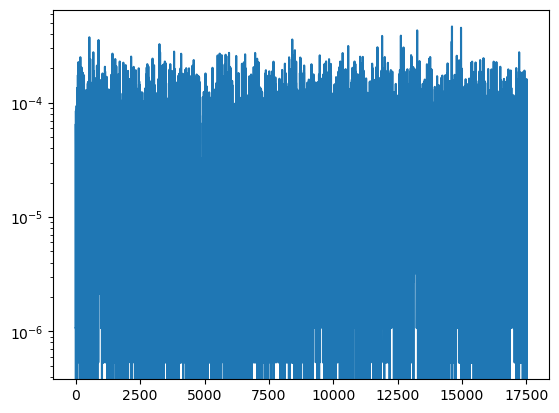

In [25]:
plt.figure()
plt.plot(kbar[epix,:],marker='o',ls='',mec='k',mew=.3)

plt.yscale('log')


In [134]:
#test=np.load('test_contrast_run_380.npz')

Text(0, 0.5, '$\\beta_{var}$')

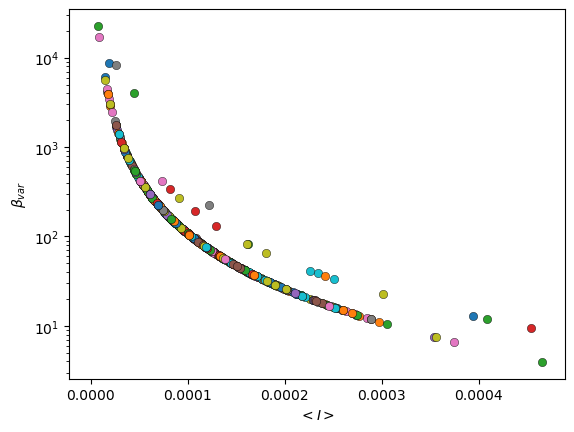

In [27]:
plt.figure()
plt.plot(kbar,beta,marker='o',ls='',mec='k',mew=.3)


plt.yscale('log')
plt.xlabel('$<I>$')
plt.ylabel(r'$\beta_{formula}$')

#plt.ylim(0,10)

In [28]:
def photon_probability(beta,kbar):
    M = 1./beta
    p1 = M*(1+M/kbar)**(-1)*(1+kbar/M)**(-M)
    p2 = M*(M+1)/2*(1+M/kbar)**(-2)*(1+kbar/M)**(-M)
    return p1,p2


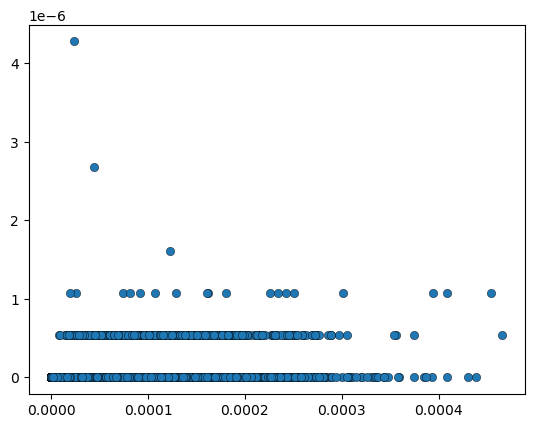

In [51]:
plt.figure()
for epix in range(N_epix):
    plt.plot(kbar[epix,:],p2[epix,:],marker='o',ls='',color='C0',label='p(1) epix'+str(epix),mec='k',mew=.3)

Text(0.5, 0, '$\\langle I \\rangle$ (count/pixel)')

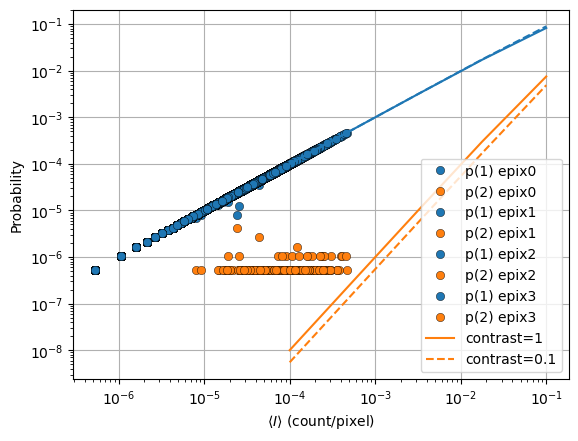

In [52]:

kbar_est = np.logspace(-4,-1,5)

contrast0=1
contrast1=.1


p1_0,p2_0 = photon_probability(contrast0,kbar_est)
p1_1,p2_1 = photon_probability(contrast1,kbar_est)

plt.figure()
#plt.plot(kbar,p0,marker='o',ls='')
for epix in range(N_epix):
    plt.plot(kbar[epix,:],p1[epix,:],marker='o',ls='',color='C0',label='p(1) epix'+str(epix),mec='k',mew=.3)
    plt.plot(kbar[epix,:],p2[epix,:],marker='o',ls='',color='C1',label='p(2) epix'+str(epix),mec='k',mew=.3)
#plt.plot(kbar,p3,marker='o',ls='')

plt.plot(kbar_est,p1_0,color='C0')
plt.plot(kbar_est,p2_0,color='C1',label='contrast='+str(contrast0))

plt.plot(kbar_est,p1_1,color='C0',ls='dashed')
plt.plot(kbar_est,p2_1,color='C1',ls='dashed',label='contrast='+str(contrast1))

#plt.plot(kbar_rebinned,p2_rebinned,marker='s',ls='',c='k')
#plt.plot(kbar_rebinned,p1_rebinned,marker='s',ls='',c='k')

#plt.hlines([1e-4,2e-4,3.5e-4,5.2e-4,],0,1)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.ylabel('Probability')
plt.xlabel(r'$\langle I \rangle$ (count/pixel)')


#plt.ylim(0,10)

In [240]:
import pyFAI


ai=pyFAI.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/mb/npys/4epix_Lab6_231103.poni')

q,I=ai.integrate1d(assemble_image(imgs),200,mask=(~mask_4img)|(assemble_image(imgs)>20))

Text(0.5, 0, '$q$')

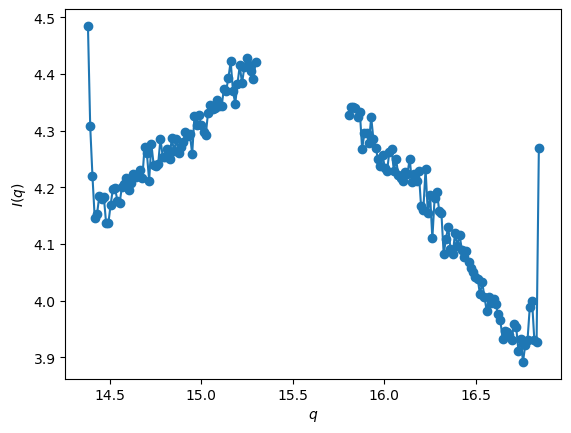

In [253]:
q0=15.3
q1=15.8
plt.figure()
plt.plot(q[(I>0)&(q<q0)],I[(I>0)&(q<q0)],marker='o',c='C0')
plt.plot(q[(I>0)&(q>q1)],I[(I>0)&(q>q1)],marker='o',c='C0')
plt.ylabel('$I(q)$')
plt.xlabel('$q$')
